In [1]:
import pandas as pd
import numpy as np
import warnings;warnings.simplefilter('ignore')
import os
import torch
import torchviz
from torch import nn
import torch.nn.functional as F
from torch import tensor
from torch.nn import Linear,ReLU,Sigmoid,Tanh,Dropout
import torch.optim as optim
import matplotlib.pyplot as plt

root = '../data/phase_2/raw/other/'
os.listdir(root)

['附件二.xlsx',
 '200mb201909.csv',
 'FCFC Import Naphtha Composition Lab_001~100_R2.xlsx',
 'Aroma-1 Unit 000 Split_Factor Calculation.xlsx',
 '200mb201701r2.csv',
 '附件一.xlsx']

# load data

In [2]:
data = pd.read_csv(root+"200mb201701r2.csv", encoding = 'big5', header = 0)
print('讀檔案 : ' + str(data.shape))
testdata = pd.read_csv(root+"200mb201909.csv", encoding = 'big5', header = 0)
# steam = dcs['ARO1-DCS-FIC55301'] + dcs['ARO1-DCS-FIC55501'] + dcs['ARO1-DCS-FIC55601']
# dcs['steam'] = steam
C9A = data['Feed    C9 Aromtics'] + data['Feed    C10+ Aromtics']
AROMA = data['Product    C9 Aromtics'] + data['Product    C10+ Aromtics']+ data['Product    Benzene']+ data['Product    Toluene']+ data['Product    Ethylbenzene']+ data['Product    P-Xylene']+ data['Product    M-Xylene']+ data['Product    O-Xylene']
data['C9A'] = C9A
data['AROMA'] = AROMA
C9A = testdata['Feed    C9 Aromtics'] + testdata['Feed    C10+ Aromtics']
AROMA = testdata['Product    C9 Aromtics'] + testdata['Product    C10+ Aromtics']+ testdata['Product    Benzene']+ testdata['Product    Toluene']+ testdata['Product    Ethylbenzene']+ testdata['Product    P-Xylene']+ testdata['Product    M-Xylene']+ testdata['Product    O-Xylene']
testdata['C9A'] = C9A
testdata['AROMA'] = AROMA

print ("Shape Of The Before Ouliers: ",data.shape)
data = data[(data["Naphtha Feed Rate, m3/hr"]<=100 )&(data["Naphtha Feed Rate, m3/hr"] >= 99)]
print ("Shape Of The After Ouliers: ",data.shape)
print ("Shape Of The Before Ouliers: ",testdata.shape)
testdata = testdata[(testdata["Naphtha Feed Rate, m3/hr"]<=100 )&(testdata["Naphtha Feed Rate, m3/hr"] >= 99)]
print ("Shape Of The After Ouliers: ",testdata.shape)
testdata.index = range(len(testdata))

讀檔案 : (829, 108)
Shape Of The Before Ouliers:  (829, 110)
Shape Of The After Ouliers:  (576, 110)
Shape Of The Before Ouliers:  (27, 110)
Shape Of The After Ouliers:  (20, 110)


# x_col

In [3]:
x_col  = [
"    N+2A in Naphtha Feed, wt%", #"ARO1-LIMS-s201-Naphthenes-ALL" + 2*"ARO1-LIMS-s201-Aromatics-ALL"
"    Chlorine in Fresh Catalyst, wt%", #"ARO1-LIMS-S307-CL"
"Carbon in Spent Catalyst, %",  #"ARO1-LIMS-S301-CARBON"  
"    C6P- in Naphtha Feed, wt%",  #"ARO1-LIMS-s201-Paraffins-6"  
"    3R211 Inlet Tem, oC",  #"ARO1-DCS-TIC20102 Setpoint"
"    3R212 Inlet Temp, oC", #"ARO1-DCS-TIC20202 Setpoint"
"    3R213 Inlet Temp, oC", #"ARO1-DCS-TIC20302 Setpoint"
"    3R214 Inlet Temp, oC", #"ARO1-DCS-TIC20402 Setpoint"
"Feed    Hydrogen",
"Feed    Methane",
"Feed    Ethane",
"Feed    Propane",
"Feed    n-Butane",
"Feed    i-Butane",
"Feed    C4 Naphthenes",
"Feed    n-Pentane",
"Feed    C5 i-Paraffins",
"Feed    C5 Naphthenes",
"Feed    n-Hexane",
"Feed    C6 i-Paraffins",
"Feed    C6 Naphthenes",
"Feed    Benzene",
"Feed    n-Heptane",
"Feed    C7 i-Paraffins",
"Feed    C7 Naphthenes",
"Feed    Toluene",
"Feed    n-Octane",
"Feed    C8 i-Paraffins",
"Feed    C8 Naphthenes",
"Feed    Ethylbenzene",
"Feed    P-Xylene",
"Feed    M-Xylene",
"Feed    O-Xylene",
"Feed    n-Nonane",
"Feed    C9 i-Paraffins",
"Feed    C9 Naphthenes",
"Feed    C9 Aromtics",
"Feed    C10+ n-Paraffins",
"Feed    C10+ i-Paraffins",
"Feed    C10+ Naphthenes",
"Feed    C10+ Aromtics",
"Product Separator Pressure, kg/cm2_g", #"ARO1-DCS-PIC21501 Setpoint"
# "Product Separator Temp, oC",
"H2/HC Ratio"                           #"ARO1-DCS-R211_HC"
         
         ]

In [4]:
x_col

['    N+2A in Naphtha Feed, wt%',
 '    Chlorine in Fresh Catalyst, wt%',
 'Carbon in Spent Catalyst, %',
 '    C6P- in Naphtha Feed, wt%',
 '    3R211 Inlet Tem, oC',
 '    3R212 Inlet Temp, oC',
 '    3R213 Inlet Temp, oC',
 '    3R214 Inlet Temp, oC',
 'Feed    Hydrogen',
 'Feed    Methane',
 'Feed    Ethane',
 'Feed    Propane',
 'Feed    n-Butane',
 'Feed    i-Butane',
 'Feed    C4 Naphthenes',
 'Feed    n-Pentane',
 'Feed    C5 i-Paraffins',
 'Feed    C5 Naphthenes',
 'Feed    n-Hexane',
 'Feed    C6 i-Paraffins',
 'Feed    C6 Naphthenes',
 'Feed    Benzene',
 'Feed    n-Heptane',
 'Feed    C7 i-Paraffins',
 'Feed    C7 Naphthenes',
 'Feed    Toluene',
 'Feed    n-Octane',
 'Feed    C8 i-Paraffins',
 'Feed    C8 Naphthenes',
 'Feed    Ethylbenzene',
 'Feed    P-Xylene',
 'Feed    M-Xylene',
 'Feed    O-Xylene',
 'Feed    n-Nonane',
 'Feed    C9 i-Paraffins',
 'Feed    C9 Naphthenes',
 'Feed    C9 Aromtics',
 'Feed    C10+ n-Paraffins',
 'Feed    C10+ i-Paraffins',
 'Feed    C10+ 

# y_col

In [5]:
script = '''
y1 = data["Product    Hydrogen"]
y2 = data["Product    Methane"]
y3 = data["Product    Ethane"]
y4 = data["Product    Propane"]
y5 = data["Product    n-Butane"]
y6 = data["Product    i-Butane"]
y7 = data["Product    C4 Naphthenes"]
y8 = data["Product    n-Pentane"]
y9 = data["Product    C5 i-Paraffins"]
y10 = data["Product    C5 Naphthenes"]
y11 = data["Product    n-Hexane"]
y12 = data["Product    C6 i-Paraffins"]
y13 = data["Product    C6 Naphthenes"]
y14 = data["Product    Benzene"]
y15 = data["Product    n-Heptane"]
y16 = data["Product    C7 i-Paraffins"]
y17 = data["Product    C7 Naphthenes"]
y18 = data["Product    Toluene"]
y19 = data["Product    n-Octane"]
y20 = data["Product    C8 i-Paraffins"]
y21 = data["Product    C8 Naphthenes"]
y22 = data["Product    Ethylbenzene"]
y23 = data["Product    P-Xylene"]
y24 = data["Product    M-Xylene"]
y25 = data["Product    O-Xylene"]
y26 = data["Product    n-Nonane"]
y27 = data["Product    C9 i-Paraffins"]
y28 = data["Product    C9 Naphthenes"]
y29 = data["Product    C9 Aromtics"]
y30 = data["Product    C10+ n-Paraffins"]
y31 = data["Product    C10+ i-Paraffins"]
y32 = data["Product    C10+ Naphthenes"]
y33 = data["Product    C10+ Aromtics"]
'''

In [6]:
y_col = []
for i in script.split('\n'):
    if ('[' in i)&(']'in i)&('Product' in i):
        s = i.index('["')+2
        e = i.index('"]')
        y_col.append(i[s:e])
y_col

['Product    Hydrogen',
 'Product    Methane',
 'Product    Ethane',
 'Product    Propane',
 'Product    n-Butane',
 'Product    i-Butane',
 'Product    C4 Naphthenes',
 'Product    n-Pentane',
 'Product    C5 i-Paraffins',
 'Product    C5 Naphthenes',
 'Product    n-Hexane',
 'Product    C6 i-Paraffins',
 'Product    C6 Naphthenes',
 'Product    Benzene',
 'Product    n-Heptane',
 'Product    C7 i-Paraffins',
 'Product    C7 Naphthenes',
 'Product    Toluene',
 'Product    n-Octane',
 'Product    C8 i-Paraffins',
 'Product    C8 Naphthenes',
 'Product    Ethylbenzene',
 'Product    P-Xylene',
 'Product    M-Xylene',
 'Product    O-Xylene',
 'Product    n-Nonane',
 'Product    C9 i-Paraffins',
 'Product    C9 Naphthenes',
 'Product    C9 Aromtics',
 'Product    C10+ n-Paraffins',
 'Product    C10+ i-Paraffins',
 'Product    C10+ Naphthenes',
 'Product    C10+ Aromtics']

# get  cleaned data

In [7]:
X_train = data[x_col]
X_test = testdata[x_col]
y_train = data[y_col]
y_test = testdata[y_col]
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((576, 43), (576, 33), (20, 43), (20, 33))

# group x_col

In [8]:
sum_col = ['Feed    Methane','Feed    Ethane','Feed    n-Butane',
          'Feed    i-Butane','Feed    C4 Naphthenes','Feed    n-Pentane','Feed    C5 i-Paraffins',
          'Feed    C5 Naphthenes','Feed    C6 i-Paraffins']

In [9]:
print(X_train.shape)
X_train['Feed    C6 i-Paraffins'] = X_train[sum_col].sum(axis=1)
X_train = X_train.drop(sum_col,axis=1)
print(X_train.shape)

(576, 43)
(576, 34)


In [10]:
print(X_test.shape)
X_test['Feed    C6 i-Paraffins'] = X_test[sum_col].sum(axis=1)
X_test = X_test.drop(sum_col,axis=1)
print(X_test.shape)

(20, 43)
(20, 34)


In [11]:
x_col = X_train.columns.tolist()
print(len(x_col))

34


# scale data

In [12]:
from sklearn.preprocessing import MinMaxScaler

mm_x = MinMaxScaler()
mm_x.fit(X_train.append(X_test))

mm_y = MinMaxScaler()
mm_y.fit(y_train.append(y_test))

X_train[:] = mm_x.transform(X_train[:])
X_test[:] = mm_x.transform(X_test[:])

y_train[:] = mm_y.transform(y_train[:])
y_test[:] = mm_y.transform(y_test[:])

# torch data_iter

In [13]:
X_train = torch.tensor(X_train.values,dtype=torch.float).cuda()
X_test = torch.tensor(X_test.values,dtype=torch.float).cuda()

y_train = torch.tensor(y_train.values,dtype=torch.float).cuda()
y_test = torch.tensor(y_test.values,dtype=torch.float).cuda()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=128,shuffle=True)

# define model

In [14]:
class model4333(nn.Module):
    def __init__(self,input_shape,output_shape):
        super(model4333,self).__init__()
        self.fc1 = Linear(input_shape,256)
        self.fc2 = Linear(256,128)
        self.fc3 = Linear(128,output_shape)
        self.dropout = Dropout(0.5)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc3(x))
        return x

In [15]:
def init_weights(m):
    if hasattr(m,'weight'):
        torch.nn.init.xavier_uniform(m.weight)
    if hasattr(m,'bias'):
        m.bias.data.fill_(0.01)

In [16]:
net = model4333(len(x_col),len(y_col)).cuda()
net.apply(init_weights)

model4333(
  (fc1): Linear(in_features=34, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=33, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [17]:
net(X_test[0])

tensor([0.4280, 0.3817, 0.5559, 0.5913, 0.5226, 0.5490, 0.5007, 0.5026, 0.4950,
        0.4650, 0.5217, 0.5802, 0.6486, 0.4897, 0.5116, 0.5062, 0.4758, 0.4908,
        0.4812, 0.5412, 0.4790, 0.5619, 0.3819, 0.4571, 0.5755, 0.4784, 0.5290,
        0.6256, 0.4441, 0.4908, 0.5510, 0.5513, 0.5754], device='cuda:0',
       grad_fn=<SigmoidBackward>)

# loss and opt

In [18]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

In [19]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            
            # weight update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # record loss
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            # record loss
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
            epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = net
            print('record net')
    
    # when end all epoch plot history
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    # return best_net
    return best_net

epochs 0 train loss 0.0624 valid loss 0.0494
record net
epochs 1 train loss 0.0467 valid loss 0.0350
record net
epochs 2 train loss 0.0371 valid loss 0.0247
record net
epochs 3 train loss 0.0307 valid loss 0.0203
record net
epochs 4 train loss 0.0299 valid loss 0.0191
record net
epochs 5 train loss 0.0276 valid loss 0.0182
record net
epochs 6 train loss 0.0256 valid loss 0.0182
record net
epochs 7 train loss 0.0236 valid loss 0.0179
record net
epochs 8 train loss 0.0227 valid loss 0.0168
record net
epochs 9 train loss 0.0220 valid loss 0.0159
record net
epochs 10 train loss 0.0209 valid loss 0.0154
record net
epochs 11 train loss 0.0197 valid loss 0.0150
record net
epochs 12 train loss 0.0195 valid loss 0.0144
record net
epochs 13 train loss 0.0191 valid loss 0.0144
epochs 14 train loss 0.0180 valid loss 0.0137
record net
epochs 15 train loss 0.0180 valid loss 0.0133
record net
epochs 16 train loss 0.0175 valid loss 0.0130
record net
epochs 17 train loss 0.0169 valid loss 0.0128
record

epochs 163 train loss 0.0093 valid loss 0.0070
epochs 164 train loss 0.0093 valid loss 0.0069
epochs 165 train loss 0.0091 valid loss 0.0068
record net
epochs 166 train loss 0.0090 valid loss 0.0069
epochs 167 train loss 0.0093 valid loss 0.0069
epochs 168 train loss 0.0093 valid loss 0.0069
epochs 169 train loss 0.0091 valid loss 0.0066
record net
epochs 170 train loss 0.0092 valid loss 0.0069
epochs 171 train loss 0.0090 valid loss 0.0067
epochs 172 train loss 0.0091 valid loss 0.0068
epochs 173 train loss 0.0089 valid loss 0.0066
record net
epochs 174 train loss 0.0087 valid loss 0.0068
epochs 175 train loss 0.0091 valid loss 0.0067
epochs 176 train loss 0.0089 valid loss 0.0068
epochs 177 train loss 0.0094 valid loss 0.0068
epochs 178 train loss 0.0089 valid loss 0.0067
epochs 179 train loss 0.0091 valid loss 0.0068
epochs 180 train loss 0.0088 valid loss 0.0065
record net
epochs 181 train loss 0.0092 valid loss 0.0066
epochs 182 train loss 0.0088 valid loss 0.0065
epochs 183 train

epochs 339 train loss 0.0071 valid loss 0.0052
record net
epochs 340 train loss 0.0075 valid loss 0.0054
epochs 341 train loss 0.0075 valid loss 0.0052
epochs 342 train loss 0.0076 valid loss 0.0052
record net
epochs 343 train loss 0.0075 valid loss 0.0053
epochs 344 train loss 0.0073 valid loss 0.0052
record net
epochs 345 train loss 0.0075 valid loss 0.0052
epochs 346 train loss 0.0075 valid loss 0.0051
record net
epochs 347 train loss 0.0075 valid loss 0.0052
epochs 348 train loss 0.0073 valid loss 0.0051
record net
epochs 349 train loss 0.0073 valid loss 0.0052
epochs 350 train loss 0.0073 valid loss 0.0052
epochs 351 train loss 0.0075 valid loss 0.0051
epochs 352 train loss 0.0073 valid loss 0.0051
epochs 353 train loss 0.0071 valid loss 0.0052
epochs 354 train loss 0.0073 valid loss 0.0051
epochs 355 train loss 0.0073 valid loss 0.0051
epochs 356 train loss 0.0075 valid loss 0.0052
epochs 357 train loss 0.0074 valid loss 0.0052
epochs 358 train loss 0.0073 valid loss 0.0053
epoch

epochs 519 train loss 0.0063 valid loss 0.0042
epochs 520 train loss 0.0064 valid loss 0.0043
epochs 521 train loss 0.0064 valid loss 0.0042
record net
epochs 522 train loss 0.0063 valid loss 0.0043
epochs 523 train loss 0.0063 valid loss 0.0042
record net
epochs 524 train loss 0.0064 valid loss 0.0043
epochs 525 train loss 0.0065 valid loss 0.0044
epochs 526 train loss 0.0066 valid loss 0.0043
epochs 527 train loss 0.0063 valid loss 0.0042
epochs 528 train loss 0.0063 valid loss 0.0043
epochs 529 train loss 0.0066 valid loss 0.0043
epochs 530 train loss 0.0064 valid loss 0.0043
epochs 531 train loss 0.0064 valid loss 0.0043
epochs 532 train loss 0.0063 valid loss 0.0042
epochs 533 train loss 0.0063 valid loss 0.0042
epochs 534 train loss 0.0064 valid loss 0.0041
record net
epochs 535 train loss 0.0066 valid loss 0.0043
epochs 536 train loss 0.0062 valid loss 0.0042
epochs 537 train loss 0.0065 valid loss 0.0042
epochs 538 train loss 0.0064 valid loss 0.0045
epochs 539 train loss 0.006

epochs 691 train loss 0.0058 valid loss 0.0038
epochs 692 train loss 0.0058 valid loss 0.0037
record net
epochs 693 train loss 0.0057 valid loss 0.0038
epochs 694 train loss 0.0059 valid loss 0.0037
epochs 695 train loss 0.0058 valid loss 0.0038
epochs 696 train loss 0.0059 valid loss 0.0037
epochs 697 train loss 0.0058 valid loss 0.0038
epochs 698 train loss 0.0058 valid loss 0.0037
epochs 699 train loss 0.0059 valid loss 0.0037
epochs 700 train loss 0.0059 valid loss 0.0038
epochs 701 train loss 0.0057 valid loss 0.0038
epochs 702 train loss 0.0058 valid loss 0.0037
epochs 703 train loss 0.0058 valid loss 0.0038
epochs 704 train loss 0.0057 valid loss 0.0037
epochs 705 train loss 0.0059 valid loss 0.0038
epochs 706 train loss 0.0059 valid loss 0.0039
epochs 707 train loss 0.0058 valid loss 0.0038
epochs 708 train loss 0.0061 valid loss 0.0038
epochs 709 train loss 0.0059 valid loss 0.0038
epochs 710 train loss 0.0057 valid loss 0.0037
epochs 711 train loss 0.0059 valid loss 0.0037
ep

epochs 874 train loss 0.0055 valid loss 0.0035
epochs 875 train loss 0.0054 valid loss 0.0034
epochs 876 train loss 0.0056 valid loss 0.0033
epochs 877 train loss 0.0055 valid loss 0.0033
epochs 878 train loss 0.0052 valid loss 0.0033
epochs 879 train loss 0.0054 valid loss 0.0033
epochs 880 train loss 0.0055 valid loss 0.0032
record net
epochs 881 train loss 0.0054 valid loss 0.0032
epochs 882 train loss 0.0055 valid loss 0.0034
epochs 883 train loss 0.0053 valid loss 0.0033
epochs 884 train loss 0.0055 valid loss 0.0033
epochs 885 train loss 0.0055 valid loss 0.0034
epochs 886 train loss 0.0054 valid loss 0.0033
epochs 887 train loss 0.0054 valid loss 0.0032
epochs 888 train loss 0.0054 valid loss 0.0035
epochs 889 train loss 0.0055 valid loss 0.0033
epochs 890 train loss 0.0053 valid loss 0.0033
epochs 891 train loss 0.0052 valid loss 0.0034
epochs 892 train loss 0.0052 valid loss 0.0034
epochs 893 train loss 0.0054 valid loss 0.0032
epochs 894 train loss 0.0053 valid loss 0.0032
ep

epochs 1048 train loss 0.0053 valid loss 0.0030
epochs 1049 train loss 0.0050 valid loss 0.0029
record net
epochs 1050 train loss 0.0050 valid loss 0.0030
epochs 1051 train loss 0.0051 valid loss 0.0031
epochs 1052 train loss 0.0053 valid loss 0.0030
epochs 1053 train loss 0.0052 valid loss 0.0029
epochs 1054 train loss 0.0053 valid loss 0.0031
epochs 1055 train loss 0.0050 valid loss 0.0030
epochs 1056 train loss 0.0050 valid loss 0.0031
epochs 1057 train loss 0.0051 valid loss 0.0029
epochs 1058 train loss 0.0051 valid loss 0.0029
epochs 1059 train loss 0.0051 valid loss 0.0029
record net
epochs 1060 train loss 0.0050 valid loss 0.0030
epochs 1061 train loss 0.0051 valid loss 0.0030
epochs 1062 train loss 0.0051 valid loss 0.0030
epochs 1063 train loss 0.0049 valid loss 0.0029
epochs 1064 train loss 0.0052 valid loss 0.0029
epochs 1065 train loss 0.0050 valid loss 0.0031
epochs 1066 train loss 0.0050 valid loss 0.0031
epochs 1067 train loss 0.0053 valid loss 0.0030
epochs 1068 train 

epochs 1220 train loss 0.0048 valid loss 0.0028
epochs 1221 train loss 0.0049 valid loss 0.0027
epochs 1222 train loss 0.0048 valid loss 0.0028
epochs 1223 train loss 0.0050 valid loss 0.0027
epochs 1224 train loss 0.0049 valid loss 0.0026
record net
epochs 1225 train loss 0.0047 valid loss 0.0027
epochs 1226 train loss 0.0049 valid loss 0.0028
epochs 1227 train loss 0.0048 valid loss 0.0028
epochs 1228 train loss 0.0048 valid loss 0.0028
epochs 1229 train loss 0.0049 valid loss 0.0028
epochs 1230 train loss 0.0048 valid loss 0.0026
record net
epochs 1231 train loss 0.0048 valid loss 0.0027
epochs 1232 train loss 0.0050 valid loss 0.0028
epochs 1233 train loss 0.0049 valid loss 0.0027
epochs 1234 train loss 0.0046 valid loss 0.0027
epochs 1235 train loss 0.0049 valid loss 0.0027
epochs 1236 train loss 0.0047 valid loss 0.0026
epochs 1237 train loss 0.0047 valid loss 0.0028
epochs 1238 train loss 0.0050 valid loss 0.0029
epochs 1239 train loss 0.0048 valid loss 0.0027
epochs 1240 train 

epochs 1391 train loss 0.0050 valid loss 0.0026
epochs 1392 train loss 0.0047 valid loss 0.0026
epochs 1393 train loss 0.0048 valid loss 0.0026
epochs 1394 train loss 0.0047 valid loss 0.0025
epochs 1395 train loss 0.0046 valid loss 0.0025
epochs 1396 train loss 0.0045 valid loss 0.0024
epochs 1397 train loss 0.0046 valid loss 0.0025
epochs 1398 train loss 0.0049 valid loss 0.0026
epochs 1399 train loss 0.0045 valid loss 0.0025
epochs 1400 train loss 0.0044 valid loss 0.0025
epochs 1401 train loss 0.0047 valid loss 0.0024
epochs 1402 train loss 0.0047 valid loss 0.0024
epochs 1403 train loss 0.0046 valid loss 0.0025
epochs 1404 train loss 0.0046 valid loss 0.0026
epochs 1405 train loss 0.0046 valid loss 0.0024
epochs 1406 train loss 0.0047 valid loss 0.0026
epochs 1407 train loss 0.0044 valid loss 0.0026
epochs 1408 train loss 0.0047 valid loss 0.0025
epochs 1409 train loss 0.0049 valid loss 0.0025
epochs 1410 train loss 0.0046 valid loss 0.0025
epochs 1411 train loss 0.0048 valid loss

epochs 1569 train loss 0.0046 valid loss 0.0024
epochs 1570 train loss 0.0044 valid loss 0.0023
epochs 1571 train loss 0.0045 valid loss 0.0025
epochs 1572 train loss 0.0047 valid loss 0.0025
epochs 1573 train loss 0.0047 valid loss 0.0024
epochs 1574 train loss 0.0047 valid loss 0.0024
epochs 1575 train loss 0.0045 valid loss 0.0023
epochs 1576 train loss 0.0045 valid loss 0.0024
epochs 1577 train loss 0.0044 valid loss 0.0023
epochs 1578 train loss 0.0044 valid loss 0.0023
epochs 1579 train loss 0.0045 valid loss 0.0023
epochs 1580 train loss 0.0044 valid loss 0.0024
epochs 1581 train loss 0.0044 valid loss 0.0023
epochs 1582 train loss 0.0044 valid loss 0.0024
epochs 1583 train loss 0.0044 valid loss 0.0023
record net
epochs 1584 train loss 0.0043 valid loss 0.0023
record net
epochs 1585 train loss 0.0044 valid loss 0.0024
epochs 1586 train loss 0.0046 valid loss 0.0023
epochs 1587 train loss 0.0044 valid loss 0.0023
epochs 1588 train loss 0.0043 valid loss 0.0024
epochs 1589 train 

epochs 1744 train loss 0.0044 valid loss 0.0023
epochs 1745 train loss 0.0044 valid loss 0.0021
record net
epochs 1746 train loss 0.0043 valid loss 0.0021
record net
epochs 1747 train loss 0.0043 valid loss 0.0022
epochs 1748 train loss 0.0044 valid loss 0.0022
epochs 1749 train loss 0.0047 valid loss 0.0022
epochs 1750 train loss 0.0043 valid loss 0.0022
epochs 1751 train loss 0.0041 valid loss 0.0022
epochs 1752 train loss 0.0044 valid loss 0.0022
epochs 1753 train loss 0.0045 valid loss 0.0021
record net
epochs 1754 train loss 0.0045 valid loss 0.0022
epochs 1755 train loss 0.0044 valid loss 0.0022
epochs 1756 train loss 0.0045 valid loss 0.0021
record net
epochs 1757 train loss 0.0044 valid loss 0.0022
epochs 1758 train loss 0.0044 valid loss 0.0022
epochs 1759 train loss 0.0043 valid loss 0.0022
epochs 1760 train loss 0.0046 valid loss 0.0022
epochs 1761 train loss 0.0044 valid loss 0.0024
epochs 1762 train loss 0.0044 valid loss 0.0023
epochs 1763 train loss 0.0045 valid loss 0.0

epochs 1924 train loss 0.0044 valid loss 0.0021
epochs 1925 train loss 0.0042 valid loss 0.0021
epochs 1926 train loss 0.0043 valid loss 0.0021
epochs 1927 train loss 0.0044 valid loss 0.0020
epochs 1928 train loss 0.0044 valid loss 0.0021
epochs 1929 train loss 0.0043 valid loss 0.0020
epochs 1930 train loss 0.0041 valid loss 0.0020
epochs 1931 train loss 0.0044 valid loss 0.0021
epochs 1932 train loss 0.0043 valid loss 0.0021
epochs 1933 train loss 0.0042 valid loss 0.0022
epochs 1934 train loss 0.0040 valid loss 0.0021
epochs 1935 train loss 0.0042 valid loss 0.0021
epochs 1936 train loss 0.0043 valid loss 0.0021
epochs 1937 train loss 0.0042 valid loss 0.0020
epochs 1938 train loss 0.0043 valid loss 0.0021
epochs 1939 train loss 0.0042 valid loss 0.0022
epochs 1940 train loss 0.0042 valid loss 0.0022
epochs 1941 train loss 0.0045 valid loss 0.0021
epochs 1942 train loss 0.0043 valid loss 0.0021
epochs 1943 train loss 0.0042 valid loss 0.0021
epochs 1944 train loss 0.0042 valid loss

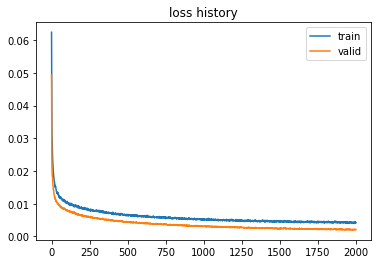

In [20]:
net = train(net,train_iter,train_iter,loss_function,optimizer,num_epochs=2000)

# make prediction

In [21]:
y_pred = net(X_test).cpu().detach().numpy()
y_pred = mm_y.inverse_transform(y_pred)
y_pred = pd.DataFrame(y_pred,columns=y_col)
y_pred.head()

,Product Hydrogen,Product Methane,Product Ethane,Product Propane,Product n-Butane,Product i-Butane,Product C4 Naphthenes,Product n-Pentane,Product C5 i-Paraffins,Product C5 Naphthenes,...,Product M-Xylene,Product O-Xylene,Product n-Nonane,Product C9 i-Paraffins,Product C9 Naphthenes,Product C9 Aromtics,Product C10+ n-Paraffins,Product C10+ i-Paraffins,Product C10+ Naphthenes,Product C10+ Aromtics
0,2558.402832,814.781433,2275.674805,2921.999023,1102.626587,1048.552246,1.124861,1739.187622,2627.485107,38.242275,...,10066.789062,5294.430664,6.959690,21.889126,19.790895,9298.419922,97.096863,198.002365,132.993256,1808.438354
1,2563.209961,830.834167,2268.330078,2786.090820,1144.000244,1107.615967,1.091371,1696.295410,2570.537842,36.940960,...,10075.337891,5291.932617,7.786424,24.326323,20.755110,9453.255859,94.494064,196.012238,130.964340,1831.370117
2,2559.761475,800.443481,2254.962646,2914.375000,1091.622192,1040.592529,1.124886,1742.806274,2628.481934,37.452553,...,10158.043945,5342.851074,6.171093,19.954706,18.335623,9189.691406,94.988472,194.523392,130.333725,1732.065918
3,2562.176025,829.138000,2258.018066,2791.916260,1130.655518,1092.664551,1.114111,1701.359009,2576.712402,36.674156,...,10099.168945,5287.917969,7.751873,25.886257,20.267359,9446.000977,95.641411,197.876282,132.444305,1828.964233
4,2560.365479,841.641479,2258.671387,2809.696777,1111.375977,1073.387817,1.121578,1715.669678,2597.111572,36.466030,...,10166.625977,5296.845703,7.712326,25.564533,19.360086,9444.396484,93.355843,192.598953,128.843307,1800.425903


In [22]:
y_real = y_test.cpu().detach().numpy()
y_real = mm_y.inverse_transform(y_real)
y_real = pd.DataFrame(y_real,columns=y_col)
y_real.head()

,Product Hydrogen,Product Methane,Product Ethane,Product Propane,Product n-Butane,Product i-Butane,Product C4 Naphthenes,Product n-Pentane,Product C5 i-Paraffins,Product C5 Naphthenes,...,Product M-Xylene,Product O-Xylene,Product n-Nonane,Product C9 i-Paraffins,Product C9 Naphthenes,Product C9 Aromtics,Product C10+ n-Paraffins,Product C10+ i-Paraffins,Product C10+ Naphthenes,Product C10+ Aromtics
0,2585.543945,783.050415,2167.787842,2652.459229,1190.827881,1204.990967,0.993305,1659.135864,2504.534424,37.759483,...,10368.238281,5203.674805,7.924977,28.818098,21.613575,9198.000977,89.397423,174.555038,119.134483,1788.525391
1,2603.471924,802.383057,2194.137207,2121.544189,1468.593384,1563.974609,0.991749,1688.823730,2555.859619,37.822845,...,10326.885742,5182.920898,8.026574,27.728163,21.890656,9217.683594,88.513573,172.790543,118.854881,1775.654785
2,2583.133789,875.061646,2180.788086,2890.277100,1133.260010,1070.766968,1.117023,1658.076660,2512.558350,37.748615,...,10314.416992,5176.662598,7.963961,27.511864,20.995895,9191.858398,94.822845,185.389496,127.154457,1778.275024
3,2569.629395,888.716736,2207.623291,2813.154541,1111.260864,1039.724121,0.992776,1702.433350,2574.746338,39.185349,...,10330.272461,5184.620117,7.294888,25.532106,21.155176,9204.890625,87.612442,169.090637,118.264397,1773.150635
4,2565.668457,887.869019,2179.576416,2809.469482,1067.980591,977.900513,1.119704,1716.807129,2595.738525,39.400585,...,10360.566406,5199.824219,7.954566,28.925694,20.971128,9265.553711,88.705460,173.766342,119.839462,1788.048950


# metric

In [23]:
from sklearn.metrics import r2_score,mean_squared_error
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
res = pd.DataFrame(index=y_col,columns=['R2','MSE','MAPE'])

for i in y_col:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
Product Hydrogen,0.470738,1702.92,1.24887
Product Methane,-0.140205,11161.2,9.51701
Product Ethane,0.289922,11407,3.81512
Product Propane,-0.279132,103708,10.1766
Product n-Butane,-0.0170108,15582.5,7.50597
Product i-Butane,-0.0360415,32150.2,11.0433
Product C4 Naphthenes,0.0576847,0.661631,11.1322
Product n-Pentane,0.504639,21780.9,5.90658
Product C5 i-Paraffins,0.501419,47050.2,5.73079
Product C5 Naphthenes,-0.481478,3.30376,4.11085


# wraper model

In [25]:
class model_4333_wraper:
    def __init__(self):
        self.x_col = x_col
        self.y_col = y_col
        self.mm_x = mm_x
        self.mm_y = mm_y
        self.net = net.eval()
    
    def predict(self,x):
        x = self.mm_x.transform(x)
        x = torch.tensor(x).cuda()
        y = self.net(x)
        y = y.detach().cpu().numpy()
        y = self.mm_y.inverse_transform(y)
        y = pd.DataFrame(y,columns=self.y_col)
        return y

In [26]:
model = model_4333_wraper()

In [27]:
X_test = pd.DataFrame(X_test.detach().cpu().numpy(),columns=x_col)

In [28]:
X_test[:] = mm_x.inverse_transform(X_test)

In [29]:
X_test.head()

,"N+2A in Naphtha Feed, wt%","Chlorine in Fresh Catalyst, wt%","Carbon in Spent Catalyst, %","C6P- in Naphtha Feed, wt%","3R211 Inlet Tem, oC","3R212 Inlet Temp, oC","3R213 Inlet Temp, oC","3R214 Inlet Temp, oC",Feed Hydrogen,Feed Propane,...,Feed n-Nonane,Feed C9 i-Paraffins,Feed C9 Naphthenes,Feed C9 Aromtics,Feed C10+ n-Paraffins,Feed C10+ i-Paraffins,Feed C10+ Naphthenes,Feed C10+ Aromtics,"Product Separator Pressure, kg/cm2_g",H2/HC Ratio
0,62.388248,0.944780,3.8015,0.519984,525.010925,525.000854,525.017944,516.013000,0.0,0.067094,...,3517.725586,6404.042480,2514.497070,1798.867554,357.764374,1413.709961,137.142532,124.334564,4.700871,1.442642
1,63.119476,0.931290,3.8320,0.528968,525.005981,525.009521,524.994446,516.015686,0.0,0.067155,...,3637.014160,6542.346680,2597.256104,1848.255615,362.016083,1410.414307,129.325073,110.656944,4.696388,1.474911
2,63.259525,0.928645,3.7630,0.551923,525.004639,525.001404,525.011169,516.004028,0.0,0.134326,...,3486.991455,5947.743164,2616.527588,1728.325195,342.066620,1336.967285,122.385384,109.738213,4.700059,1.495016
3,62.810543,0.913635,3.8590,0.522963,524.466309,525.006897,524.990540,516.009033,0.0,0.134273,...,3636.807373,6497.169922,2681.642822,1831.335693,366.754639,1421.607422,134.156174,112.465012,4.700067,1.475583
4,62.596931,0.913195,3.7770,0.544962,523.334412,524.333679,524.334839,515.984741,0.0,0.134356,...,3628.716309,6481.561035,2682.615479,1819.025513,365.363129,1411.612915,130.418716,107.192932,4.695580,1.498736


In [30]:
y_test = pd.DataFrame(y_test.detach().cpu().numpy(),columns=y_col)

In [31]:
y_test[:] = mm_y.inverse_transform(y_test)

In [32]:
y_test.head()

,Product Hydrogen,Product Methane,Product Ethane,Product Propane,Product n-Butane,Product i-Butane,Product C4 Naphthenes,Product n-Pentane,Product C5 i-Paraffins,Product C5 Naphthenes,...,Product M-Xylene,Product O-Xylene,Product n-Nonane,Product C9 i-Paraffins,Product C9 Naphthenes,Product C9 Aromtics,Product C10+ n-Paraffins,Product C10+ i-Paraffins,Product C10+ Naphthenes,Product C10+ Aromtics
0,2585.543945,783.050415,2167.787842,2652.459229,1190.827881,1204.990967,0.993305,1659.135864,2504.534424,37.759483,...,10368.238281,5203.674805,7.924977,28.818098,21.613575,9198.000977,89.397423,174.555038,119.134483,1788.525391
1,2603.471924,802.383057,2194.137207,2121.544189,1468.593384,1563.974609,0.991749,1688.823730,2555.859619,37.822845,...,10326.885742,5182.920898,8.026574,27.728163,21.890656,9217.683594,88.513573,172.790543,118.854881,1775.654785
2,2583.133789,875.061646,2180.788086,2890.277100,1133.260010,1070.766968,1.117023,1658.076660,2512.558350,37.748615,...,10314.416992,5176.662598,7.963961,27.511864,20.995895,9191.858398,94.822845,185.389496,127.154457,1778.275024
3,2569.629395,888.716736,2207.623291,2813.154541,1111.260864,1039.724121,0.992776,1702.433350,2574.746338,39.185349,...,10330.272461,5184.620117,7.294888,25.532106,21.155176,9204.890625,87.612442,169.090637,118.264397,1773.150635
4,2565.668457,887.869019,2179.576416,2809.469482,1067.980591,977.900513,1.119704,1716.807129,2595.738525,39.400585,...,10360.566406,5199.824219,7.954566,28.925694,20.971128,9265.553711,88.705460,173.766342,119.839462,1788.048950


In [33]:
y_pred = model.predict(X_test)
y_pred.head()

,Product Hydrogen,Product Methane,Product Ethane,Product Propane,Product n-Butane,Product i-Butane,Product C4 Naphthenes,Product n-Pentane,Product C5 i-Paraffins,Product C5 Naphthenes,...,Product M-Xylene,Product O-Xylene,Product n-Nonane,Product C9 i-Paraffins,Product C9 Naphthenes,Product C9 Aromtics,Product C10+ n-Paraffins,Product C10+ i-Paraffins,Product C10+ Naphthenes,Product C10+ Aromtics
0,2558.402832,814.781189,2275.674561,2921.998535,1102.626587,1048.552368,1.124861,1739.187622,2627.484863,38.242268,...,10066.787109,5294.430176,6.959692,21.889133,19.790907,9298.420898,97.096855,198.002365,132.993256,1808.438477
1,2563.209961,830.834473,2268.330078,2786.091064,1144.000122,1107.615845,1.091371,1696.295776,2570.538818,36.940968,...,10075.338867,5291.932617,7.786427,24.326338,20.755108,9453.255859,94.494034,196.012192,130.964294,1831.369629
2,2559.761475,800.443359,2254.962646,2914.375000,1091.622070,1040.592163,1.124886,1742.806030,2628.481689,37.452515,...,10158.042969,5342.851074,6.171094,19.954706,18.335629,9189.692383,94.988487,194.523376,130.333725,1732.066528
3,2562.176025,829.137817,2258.017578,2791.915771,1130.655884,1092.664917,1.114110,1701.358398,2576.711670,36.674160,...,10099.168945,5287.918457,7.751873,25.886251,20.267363,9446.000977,95.641434,197.876343,132.444336,1828.964600
4,2560.365479,841.641663,2258.672119,2809.697266,1111.375732,1073.387817,1.121579,1715.670410,2597.112793,36.466045,...,10166.625977,5296.845703,7.712338,25.564606,19.360077,9444.397461,93.355774,192.598785,128.843201,1800.425049


In [34]:
y_real = y_test

In [35]:
res = pd.DataFrame(index=y_col,columns=['R2','MSE','MAPE'])

for i in y_col:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
Product Hydrogen,0.470737,1702.92,1.24887
Product Methane,-0.140206,11161.2,9.51701
Product Ethane,0.289924,11407,3.81512
Product Propane,-0.279133,103709,10.1766
Product n-Butane,-0.01701,15582.5,7.50598
Product i-Butane,-0.0360424,32150.3,11.0433
Product C4 Naphthenes,0.0576847,0.661631,11.1322
Product n-Pentane,0.504638,21780.9,5.90659
Product C5 i-Paraffins,0.501418,47050.3,5.7308
Product C5 Naphthenes,-0.481468,3.30374,4.11085


In [36]:
import joblib
joblib.dump(model,'../model/transformer(43_to_33).pkl')

['../model/transformer(43_to_33).pkl']